# STAT 542 / CS 598: Homework 6
Fall 2019, by Edgar Pino

Due: Monday, Nov 11 by 11:59 PM Pacific Time

In [2]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from cvxopt import matrix, solvers
import math

# Question 1 [50 Points] Linearly Separable SVM using Quadratic Programming

In [4]:
np.random.seed(1)

In [5]:
COLOR_LABELS = ["darkorange","deepskyblue"]

In [6]:
N = 40
P = 2

In [7]:
xpos = np.random.normal(0, 1,(N,P))
xneg = np.random.normal(4, 1,(N,P))

In [8]:
x = np.concatenate((xpos, xneg), axis=0)
y = np.concatenate((np.ones((N,)), -np.ones((N,))), axis=0)

In [9]:
def plot_data(x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        items = x[y == unique[li]]
        label = 'Positive' if unique[li] == -1 else 'Negative'
        plt.scatter(items[:, 0], items[:, 1], c = COLOR_LABELS[li], label=label)
    plt.legend()

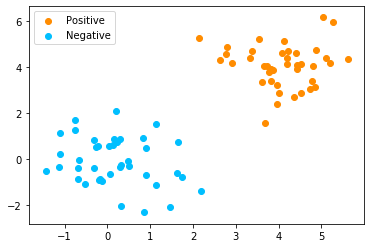

In [10]:
plot_data(x,y)

### Fit

In [42]:
def fit(x, y): 
    NUM = x.shape[0]
    DIM = x.shape[1]
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    
    return solvers.qp(P, q, G, h, A, b)

In [43]:
def plot_separator(ax, w, b):
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    x = np.arange(0, 6)
    ax.plot(x, x * slope + intercept, 'k-')
    ax.plot(x, x * slope + intercept + 2.75, '-')
    ax.plot(x, x * slope + intercept - 2.75, '-')

In [44]:
def plot_data_with_labels(x, y, ax):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        label = 'Positive' if unique[li] == 1 else 'Negative'
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLOR_LABELS[li], label=label)

In [45]:
sol = fit(x, y)
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -6.2205e+00 -1.0607e+01  2e+02  1e+01  2e+00
 1: -5.1204e+00 -1.6071e+00  3e+01  2e+00  2e-01
 2: -3.0840e-01 -5.4380e-01  5e-01  2e-02  2e-03
 3: -3.7365e-01 -4.2487e-01  9e-02  3e-03  3e-04
 4: -4.1115e-01 -4.1811e-01  9e-03  2e-04  2e-05
 5: -4.1661e-01 -4.1693e-01  3e-04  2e-06  2e-07
 6: -4.1685e-01 -4.1686e-01  6e-06  2e-08  2e-09
 7: -4.1685e-01 -4.1685e-01  6e-08  2e-10  2e-11
Optimal solution found.


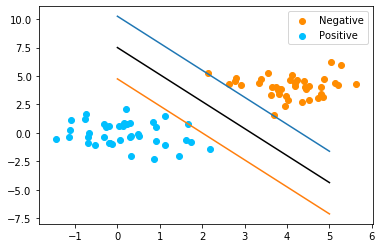

In [46]:
w = np.sum(alphas * y[:, None] * x, axis = 0)
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
bias = b[0]

norm = np.linalg.norm(w)
w, bias = w / norm, bias / norm

fig, ax = plt.subplots()
plot_separator(ax, w, bias)
plot_data_with_labels(x, y, ax)

plt.legend()
plt.show()

# Question 2 [25 Points] Linearly Non-seperable SVM using Penalized Loss

In [51]:
np.random.seed(1)

In [52]:
N = 100
P = 2

In [53]:
xpos = np.random.normal(0, 1,(N,P))
xneg = np.random.normal(1.5, 1,(N,P))

In [54]:
x = np.concatenate((xpos, xneg), axis=0)
y = np.concatenate((np.ones((N,)), -np.ones((N,))), axis=0)

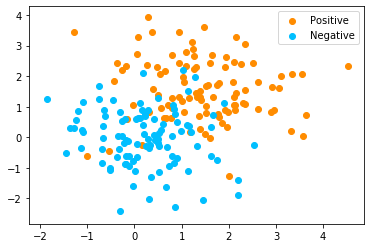

In [55]:
plot_data(x,y)

In [56]:
def loss(b, x, y):
    return np.sum(
        np.log(
            1+np.exp(
                -y*
                (b[0]+np.dot(x,np.array([b[1],b[2]])))
            ))
    )+0.5*(np.power(b[0],2)+np.power(b[1],2)+np.power(b[2],2))

In [57]:
results = minimize(loss, (1,1,1), args=(x,y))

In [58]:
intercept = -results['x'][0]/results['x'][2]

In [59]:
slope = -results['x'][1]/results['x'][2]

In [60]:
intercept

1.3611124182617051

In [61]:
slope

-0.812670650533452

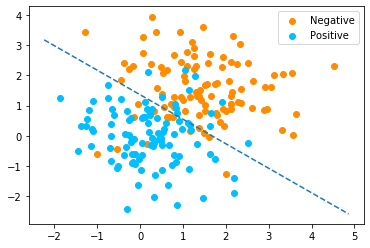

In [62]:
fig, ax = plt.subplots()
plot_data_with_labels(x, y, ax)

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
ax.plot(x_vals, y_vals, '--')

plt.legend()
plt.show()

# Question 3 [25 Points] Nonlinear and Non-seperable SVM using Penalized Loss

In [11]:
from scipy.spatial.distance import pdist
from rpy2.robjects.packages import STAP
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

In [12]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [13]:
mfunc = 'get_k <- function(x){return(as.matrix(dist(x)^2)/0.25)}'

In [14]:
myasmatrix = STAP(mfunc, "myasmatrix")

In [15]:
N = 400
P = 2

In [16]:
x = np.random.uniform(0,1,N*P).reshape(N,P)

In [17]:
side = (x[:, 1] > 0.5 + 0.3*np.sin(3*math.pi*x[:, 0]))

In [18]:
y = np.random.choice(np.array([1, -1]), N, True, np.array([0.9, 0.1]))*(side == 1) + np.random.choice(np.array([1, -1]), N, True, np.array([0.1, 0.9]))*(side == 0)

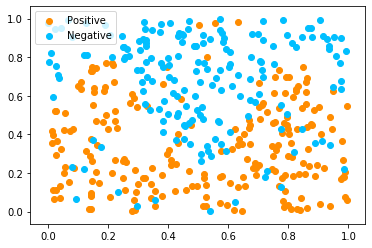

In [19]:
plot_data(x,y)

In [20]:
K = np.array(np.exp(-1 * np.array(myasmatrix.get_k(x))/.25))

In [76]:
def my_k_loss(b, k, y):
    return np.sum(
        np.log(
            1+np.exp(
                -y*np.dot(k,b)
            )
        )
    )+np.sum(0.05*b%k%b)

In [77]:
results = minimize(my_k_loss, np.ones(N), args=(K,y))

/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:696: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [79]:
results['x']

array([1.15558281, 0.70875382, 0.63669815, 0.79667738, 0.85216392,
       0.83081225, 0.84137961, 0.72032158, 0.56282701, 0.73931824,
       0.75969523, 0.8130382 , 0.83313547, 0.59302644, 0.65992754,
       0.71233993, 0.83769635, 0.89331255, 0.85564678, 0.81355223,
       0.73191985, 0.70762637, 0.81347523, 0.71927339, 0.59213222,
       0.5980843 , 0.66520484, 0.63044827, 0.61124229, 0.76951721,
       0.65332069, 0.79852725, 0.85798987, 0.5617628 , 0.81162721,
       0.92121337, 0.78153629, 0.80277459, 0.65262116, 0.86834633,
       1.29268991, 0.73676209, 0.8385555 , 0.6523749 , 0.66611628,
       0.61270135, 0.58616137, 0.85472188, 0.64655303, 0.67138266,
       0.56904923, 0.83162056, 0.74578153, 1.04213048, 0.67870159,
       0.71208931, 0.75320888, 0.79521885, 0.67741315, 0.702786  ,
       0.82368113, 0.62970758, 0.86374028, 1.31426082, 0.73519383,
       0.67212268, 0.68532017, 0.74072777, 0.61720687, 0.57829385,
       0.57903322, 0.86683974, 0.62605405, 0.66027202, 0.75668